# Пособие по Augmentation

## Использование LookGenerator.config.config

In [2]:
import os
import matplotlib.pyplot as plt
from LookGenerator.config.config import WeightsConfig

Config = WeightsConfig(os.environ)
None

{'WEIGHTS_URL': <class 'str'>, 'WEIGHTS_DIR': <class 'str'>, 'POSENET_URL': <class 'str'>, 'DATASET_DIR': <class 'str'>, 'HOUSE_ROOM_DATASET': <class 'str'>}
{'WEIGHTS_URL': <class 'str'>, 'WEIGHTS_DIR': <class 'str'>, 'POSENET_URL': <class 'str'>, 'DATASET_DIR': <class 'str'>, 'HOUSE_ROOM_DATASET': <class 'str'>}
{'WEIGHTS_URL': <class 'str'>, 'WEIGHTS_DIR': <class 'str'>, 'POSENET_URL': <class 'str'>, 'DATASET_DIR': <class 'str'>, 'HOUSE_ROOM_DATASET': <class 'str'>}
{'WEIGHTS_URL': <class 'str'>, 'WEIGHTS_DIR': <class 'str'>, 'POSENET_URL': <class 'str'>, 'DATASET_DIR': <class 'str'>, 'HOUSE_ROOM_DATASET': <class 'str'>}
{'WEIGHTS_URL': <class 'str'>, 'WEIGHTS_DIR': <class 'str'>, 'POSENET_URL': <class 'str'>, 'DATASET_DIR': <class 'str'>, 'HOUSE_ROOM_DATASET': <class 'str'>}
{'WEIGHTS_URL': <class 'str'>, 'WEIGHTS_DIR': <class 'str'>, 'POSENET_URL': <class 'str'>, 'DATASET_DIR': <class 'str'>, 'HOUSE_ROOM_DATASET': <class 'str'>}
{'WEIGHTS_URL': <class 'str'>, 'WEIGHTS_DIR': <class

In [3]:
Config.DATASET_DIR

'C:\\Users\\zanoo\\PycharmProjects\\zalando-hd-resized'

## Импорт изображений человека и фона

In [4]:
from LookGenerator.datasets.person_segmantation_dataset import PersonSegmentationDataset

dataset = PersonSegmentationDataset(os.path.join(Config.DATASET_DIR, "train"))

In [5]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage

In [6]:
def print_person_image(data_of_image):
    fig = plt.figure(figsize=(10, 7))

    fig.add_subplot(1,2, 1)
    plt.imshow(ToPILImage()(data_of_image[0]))

    fig.add_subplot(1,2, 2)
    plt.imshow(ToPILImage()(data_of_image[1]))

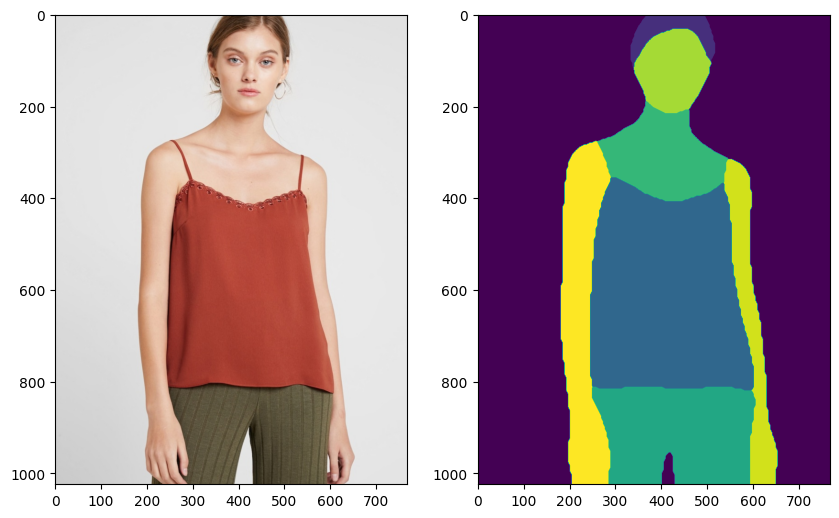

In [7]:
image = dataset.__getitem__(0)

print_person_image(image)

In [8]:
image[1]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

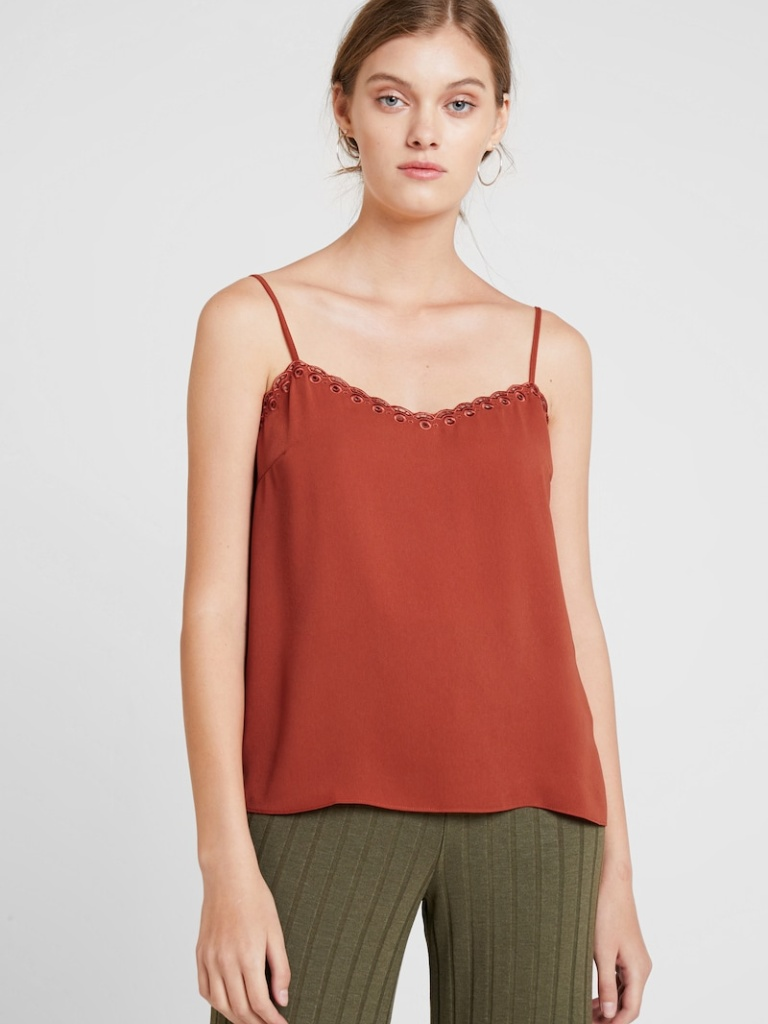

In [9]:
ToPILImage()(image[0])

In [1]:
sum = 0
for i in image[1]:
    for j in i:
        sum+=1

NameError: name 'image' is not defined

In [ ]:
1024*756